In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
dataset_url='http://files.fast.ai/data/cifar10.tgz'
download_url(dataset_url, '.')

In [3]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
data_dir='./data/cifar10'
print(os.listdir(data_dir))

['train', 'labels.txt', 'test']


In [5]:
classes=os.listdir(data_dir+'/train')
classes

['dog',
 'deer',
 'cat',
 'automobile',
 'airplane',
 'horse',
 'frog',
 'ship',
 'truck',
 'bird']

In [6]:
len_train_deer=len(os.listdir(data_dir+'/train/deer'))
print(len_train_deer)
len_test_deer=len(os.listdir(data_dir+'/test/deer'))
print(len_test_deer)

5000
1000


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [8]:
dataset=ImageFolder(data_dir+'/train', transform=ToTensor())

In [9]:
image, label = dataset[40000]
print(image, label)

tensor([[[0.3843, 0.3569, 0.3216,  ..., 0.4235, 0.4078, 0.4078],
         [0.7804, 0.8627, 0.8902,  ..., 0.7176, 0.6078, 0.7451],
         [0.8510, 0.8471, 0.8510,  ..., 0.6588, 0.6000, 0.6431],
         ...,
         [0.3216, 0.3255, 0.3176,  ..., 0.3020, 0.3294, 0.3333],
         [0.3059, 0.3098, 0.3412,  ..., 0.2510, 0.3137, 0.3294],
         [0.3176, 0.3255, 0.3216,  ..., 0.2863, 0.3059, 0.3216]],

        [[0.3529, 0.3255, 0.2941,  ..., 0.4000, 0.3961, 0.4039],
         [0.7333, 0.8157, 0.8431,  ..., 0.6667, 0.5647, 0.7098],
         [0.8000, 0.7922, 0.7961,  ..., 0.6235, 0.5725, 0.6235],
         ...,
         [0.4314, 0.4275, 0.3765,  ..., 0.4118, 0.4353, 0.4392],
         [0.4157, 0.4078, 0.4235,  ..., 0.3608, 0.4196, 0.4353],
         [0.4196, 0.4196, 0.4196,  ..., 0.3961, 0.4118, 0.4275]],

        [[0.3176, 0.2784, 0.2392,  ..., 0.3529, 0.3294, 0.3451],
         [0.6588, 0.7490, 0.7843,  ..., 0.6157, 0.5176, 0.6745],
         [0.7098, 0.7137, 0.7216,  ..., 0.5255, 0.4980, 0.

Label:  ship (8)


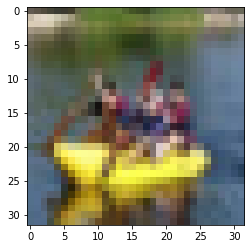

In [10]:
import matplotlib.pyplot as plt
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
show_example(*dataset[40000])

In [11]:
import numpy as np

def split_indices(n, val):
    n_val=int(n*val)
    indx=np.random.permutation(n)
    return indx[:n_val], indx[n_val:]

val_indices, train_indices=split_indices(len(dataset), 0.2)
print(len(train_indices), len(val_indices))

40000 10000


In [12]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [13]:
batch_size=128
train_sampler=SubsetRandomSampler(train_indices)
train_dl=DataLoader(dataset, batch_size, sampler=train_sampler)
valid_sampler=SubsetRandomSampler(val_indices)
valid_dl=DataLoader(dataset, batch_size, sampler=valid_sampler)

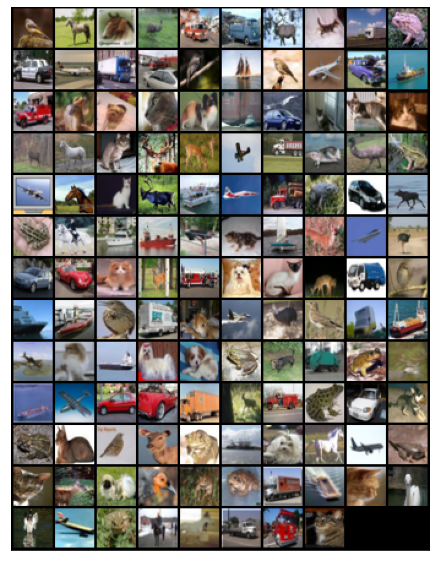

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1, 2, 0))
        break
show_batch(train_dl)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
model=nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3, stride=1, padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,32,kernel_size=3, stride=1, padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(32,64,kernel_size=3, stride=1, padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(64,128,kernel_size=3, stride=1, padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(128,128,kernel_size=3, stride=1, padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Flatten(),
    nn.Linear(128,10)
    )

In [17]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [18]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [19]:
class Device_DataLoader():
    def __init__(self, dl, device):
        self.dl=dl
        self.device=device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = Device_DataLoader(train_dl, device)
valid_dl = Device_DataLoader(valid_dl, device)
to_device(model, device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten()
  (16): Linear(in_features=128, out_features=10, bias=True)
)

In [22]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)
                     
    if opt is not None:
        loss.backward()            
        opt.step()
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [23]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb,yb in valid_dl]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [24]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, 
        opt_fn=None, lr=None, metric=None):
    train_losses, val_losses, val_metrics = [], [], []
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            train_loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        if metric is None:
            print('Epoch [{}/{}], train_loss: {:4f}, val_loss: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss))
        else:
            print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss, 
                          metric.__name__, val_metric))
    return train_losses, val_losses, val_metrics

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [26]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, 
                                    valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3048, Accuracy: 0.0996


In [27]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr = 0.005

In [28]:
history = fit(num_epochs, model, F.cross_entropy, 
              train_dl, valid_dl, opt_fn, lr, accuracy)
train_losses, val_losses, val_metrics = history

Epoch [1/10], train_loss: 1.5977, val_loss: 1.6190, val_accuracy: 0.3997
Epoch [2/10], train_loss: 1.3426, val_loss: 1.4031, val_accuracy: 0.4910
Epoch [3/10], train_loss: 1.1073, val_loss: 1.3845, val_accuracy: 0.5100
Epoch [4/10], train_loss: 1.0368, val_loss: 1.2053, val_accuracy: 0.5714
Epoch [5/10], train_loss: 0.9654, val_loss: 1.2024, val_accuracy: 0.5790
Epoch [6/10], train_loss: 1.2577, val_loss: 1.1751, val_accuracy: 0.5818
Epoch [7/10], train_loss: 0.8998, val_loss: 1.1399, val_accuracy: 0.6052
Epoch [8/10], train_loss: 1.0460, val_loss: 1.1423, val_accuracy: 0.6049
Epoch [9/10], train_loss: 0.9899, val_loss: 1.0970, val_accuracy: 0.6150
Epoch [10/10], train_loss: 0.9377, val_loss: 1.1268, val_accuracy: 0.6140


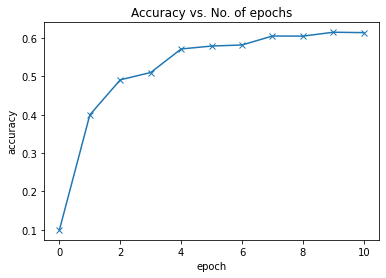

In [29]:
def plot_metric(metric_values):
    """Plot metric values in a line graph"""
    plt.plot(metric_values, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_metric([val_acc] + val_metrics)

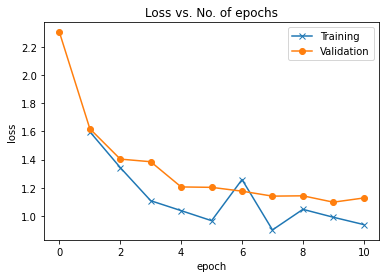

In [30]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, '-x')
    plt.plot(val_losses, '-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses([None]+train_losses, [val_loss]+val_losses)

In [31]:
test_dataset=ImageFolder(data_dir+'/test', transform=ToTensor())

In [32]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


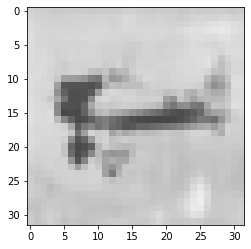

In [33]:
img, label = test_dataset[3]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [36]:
test_loader = DataLoader(test_dataset, batch_size=200)
test_dl = Device_DataLoader(test_loader, device)
test_loss, total, test_acc = evaluate(model, F.cross_entropy, test_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))

Loss: 1.1086, Accuracy: 0.6171


In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')
